# 数据探索

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [18]:
sns.set_theme(style="whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


In [21]:
path='../data/train.csv'
train_data=pd.read_csv(path,parse_dates=['Date'])
print("序列长度为：",len(train_data))
train_data.head()

/tmp/ipykernel_8741/3439670201.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data=pd.read_csv(path,parse_dates=['Date'])


序列长度为： 1017209


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


我们发现有多个不同店铺，按店铺不同商品的数据，因此需要group操作

In [22]:
set1=set(train_data['Store'])
print("店铺数量：",len(set1))

店铺数量： 1115


我们将用店铺1的时序特征来分析

In [ ]:
store1=train_data[train_data['Store']==1]
store1.sort_values(by='Date',ascending=True,inplace=True)
store1=store1.set_index('Date').to_period('D')
print('商店1的序列长度为：',len(store1))
store1.head()

商店1的序列长度为： 942


/tmp/ipykernel_8741/382027971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store1.sort_values(by='Date',ascending=True,inplace=True)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1
2013-01-02,1,3,5530,668,1,0,0,1
2013-01-03,1,4,4327,578,1,0,0,1
2013-01-04,1,5,4486,619,1,0,0,1
2013-01-05,1,6,4997,635,1,0,0,1


In [36]:
store1.tail()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,time_dummy
Date,,,,,,,,,
2015-07-27,1,1,6102,612,1,1,0,1,937
2015-07-28,1,2,5011,560,1,1,0,1,938
2015-07-29,1,3,4782,523,1,1,0,1,939
2015-07-30,1,4,5020,546,1,1,0,1,940
2015-07-31,1,5,5263,555,1,1,0,1,941


## 1.1 对商店1sales的趋势分析

<Axes: xlabel='time_dummy', ylabel='Sales'>

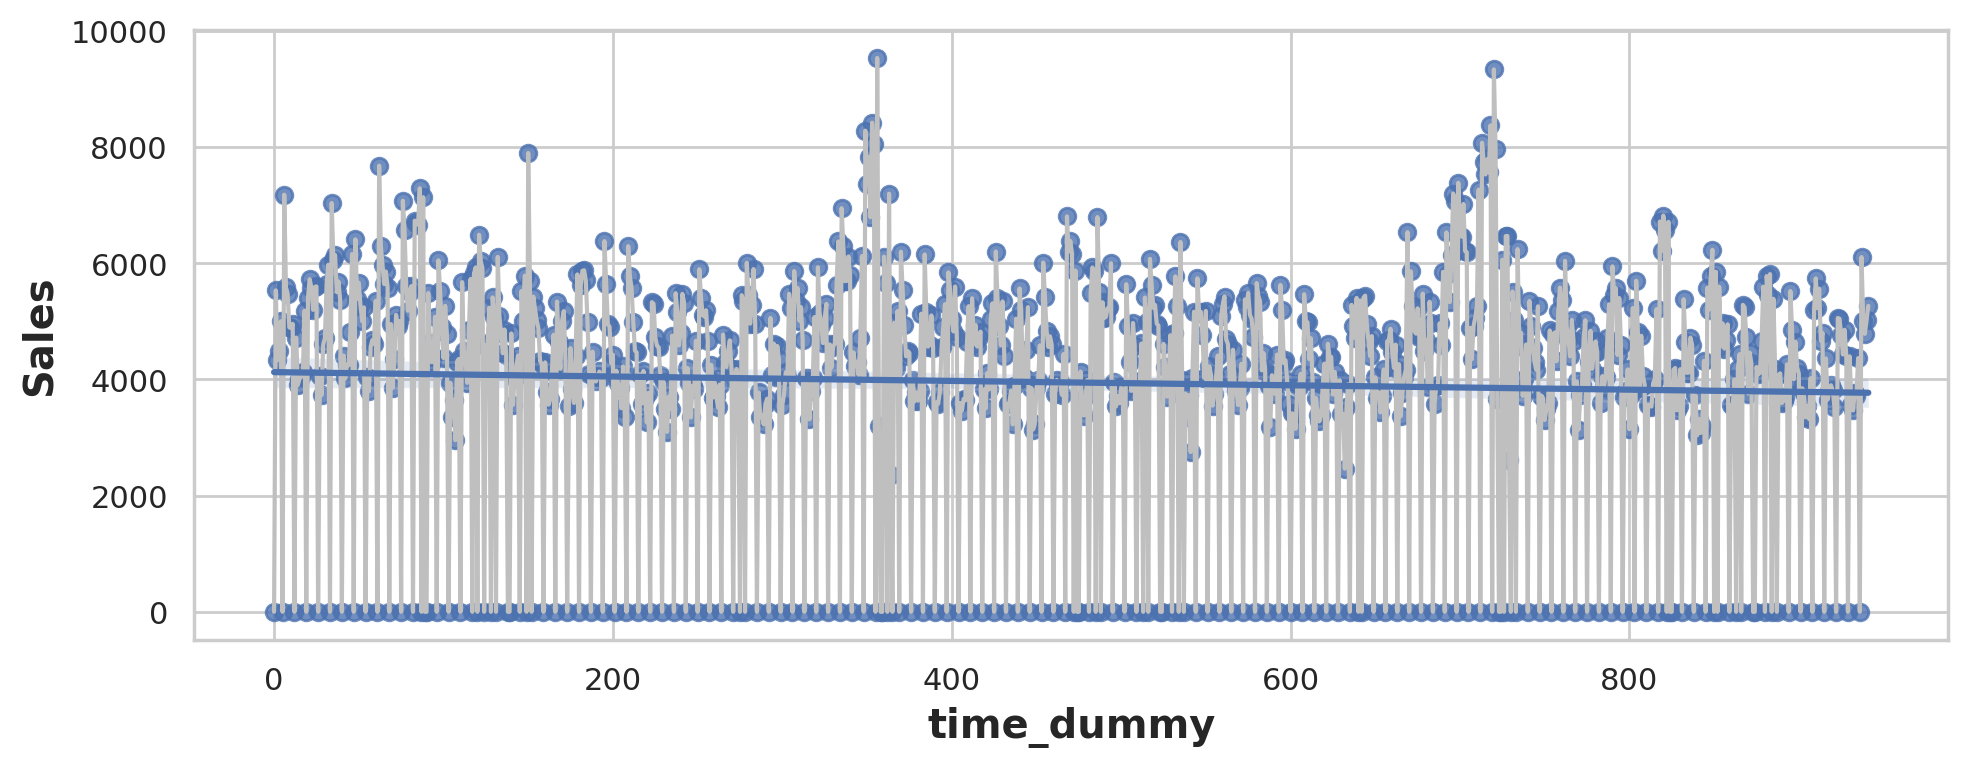

In [34]:
store1['time_dummy']=np.arange(len(store1))
ig, ax = plt.subplots(figsize=(10, 4))
ax.plot('time_dummy','Sales',data=store1,color='0.75')
sns.regplot(x='time_dummy',y='Sales',data=store1,ax=ax)

可以发现销售量随天数变化呈现出强周期性，并且趋势平稳。且存在一些销售量为0的异常点，可能是由于节假日。我们用rolling_mean来平滑一下

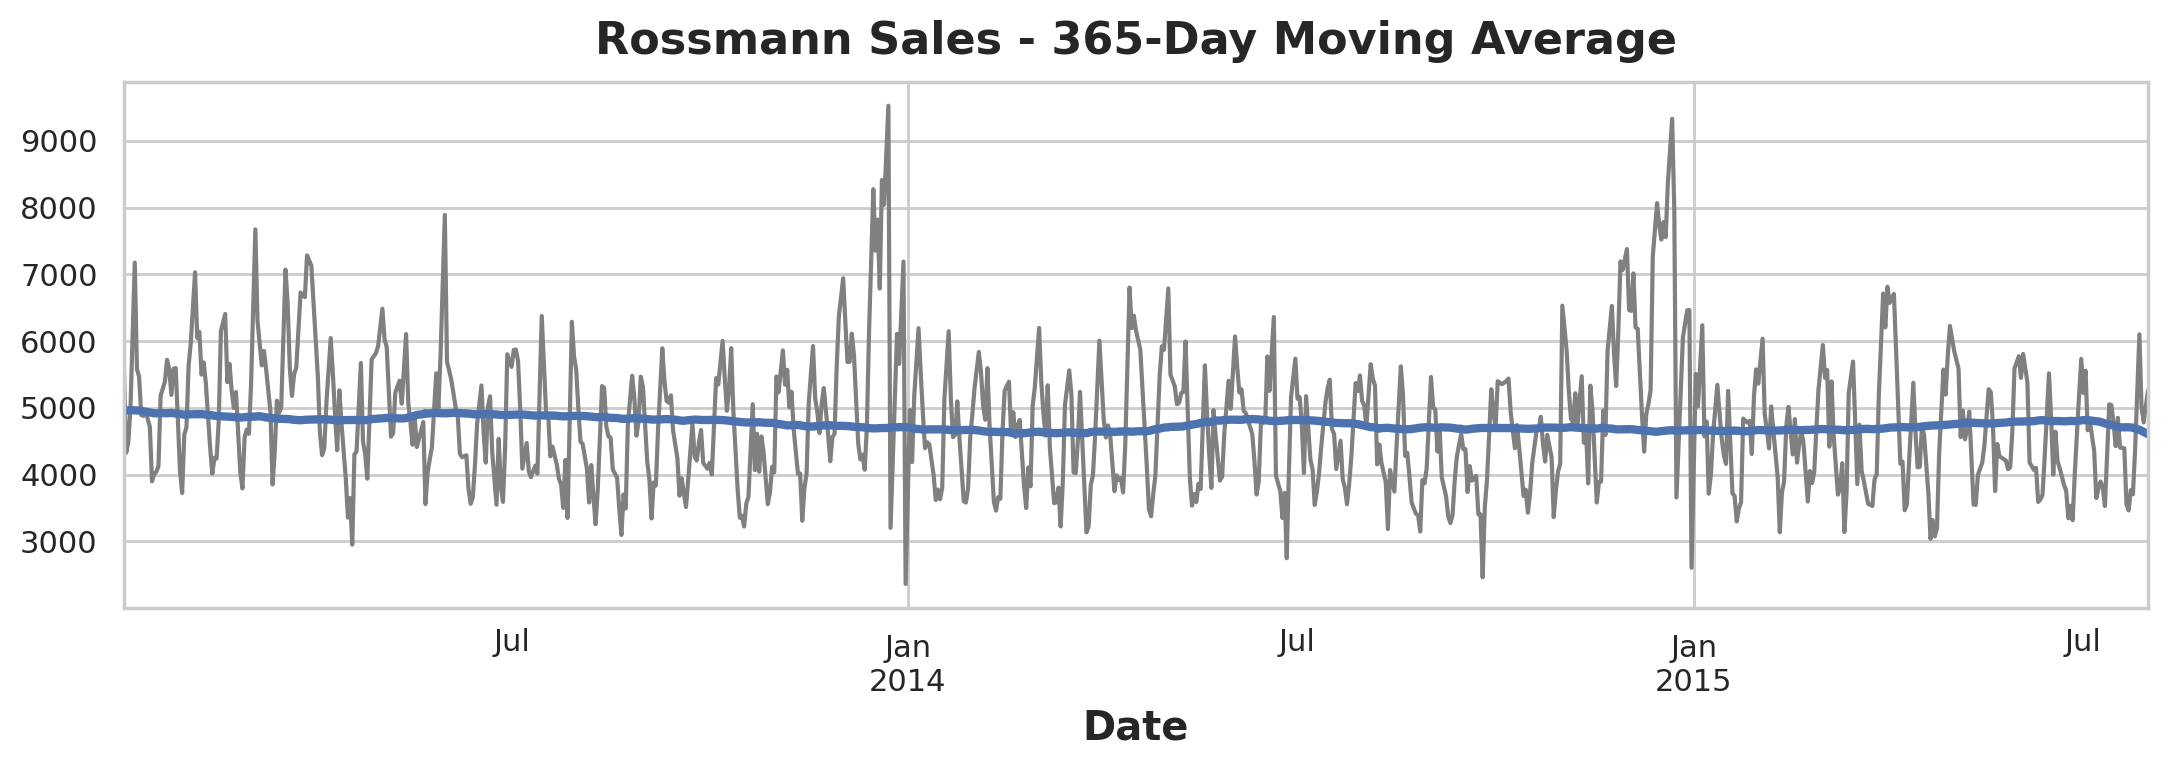

In [48]:
move_average=store1[store1['Sales']!=0]['Sales'].rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()
ax=store1[store1['Sales']!=0]['Sales'].plot(color='0.5')
move_average.plot(ax=ax, linewidth=3, title="Rossmann Sales - 365-Day Moving Average", legend=False,);


我们将sales不为0的部分拿出来做rolling meanean，可以看到趋势平稳，周期性明显。由于高度平稳的趋势，我考虑直接使用gbdt

## 1.2、对store1的customer趋势分析

我们用相同方法分析customer的趋势

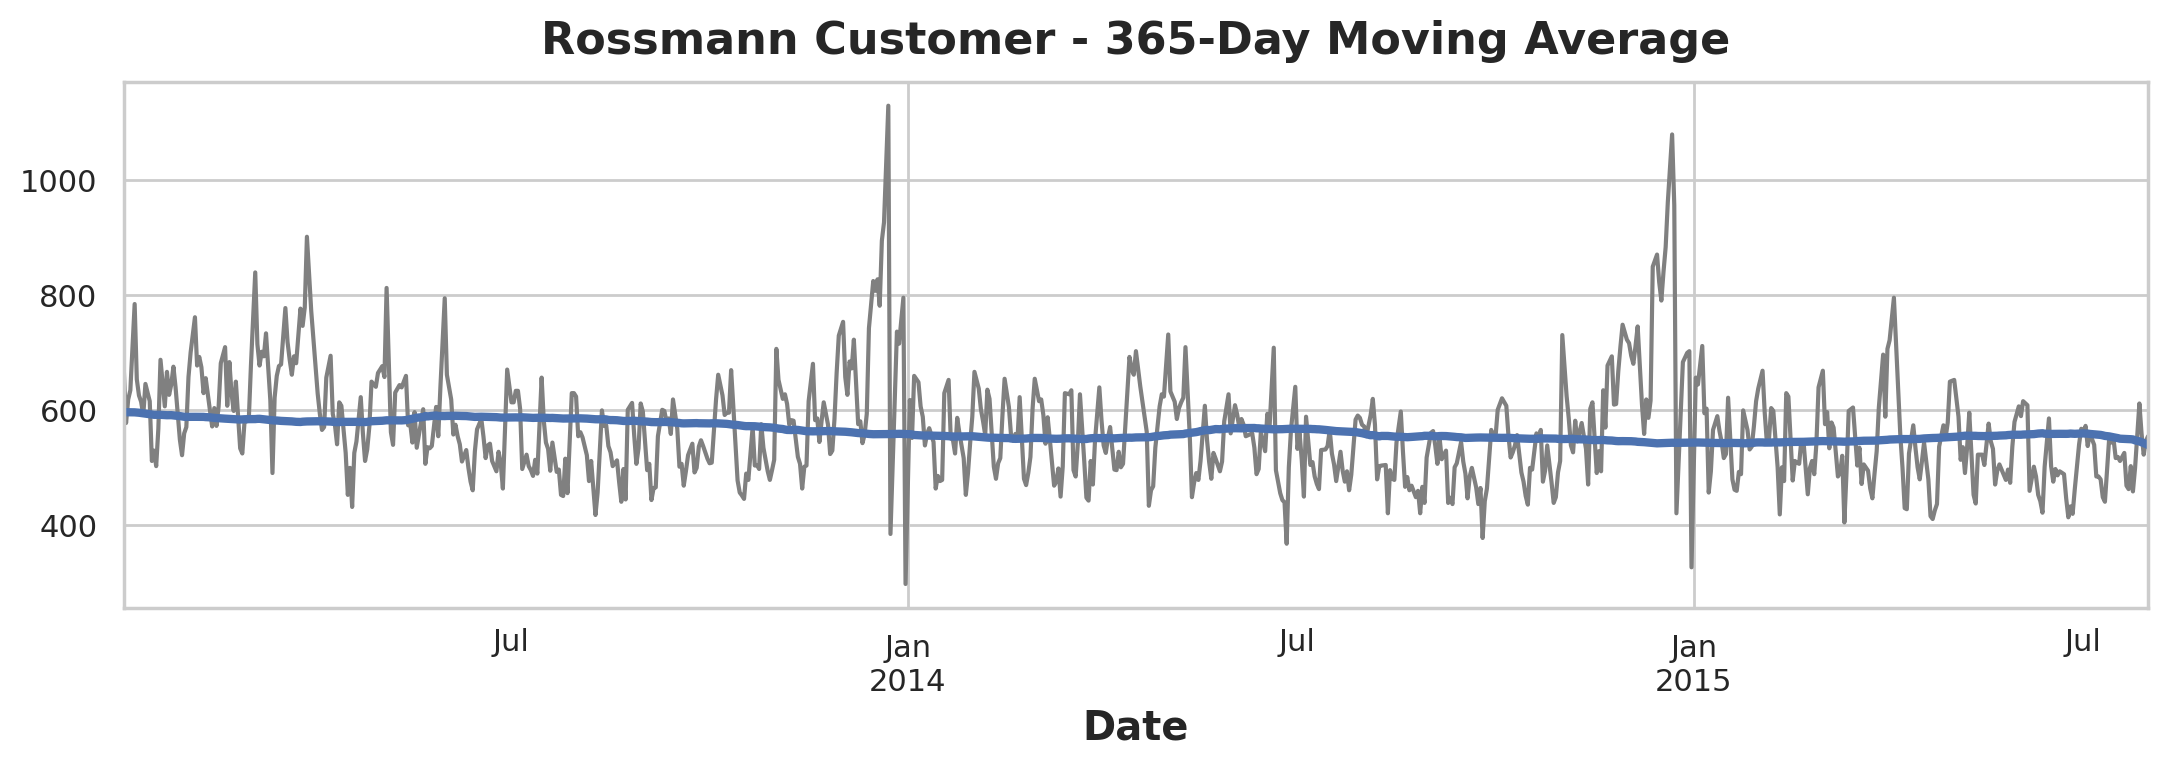

In [50]:
move_average=store1[store1['Customers']!=0]['Customers'].rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()
ax=store1[store1['Customers']!=0]['Customers'].plot(color='0.5')
move_average.plot(ax=ax, linewidth=3, title="Rossmann Customer - 365-Day Moving Average", legend=False,);

我们发现顾客有着类似的、微小的略微下降趋势。它们都呈现出高噪声和强周期性。

## 2、 对store1的季节性分析

/tmp/ipykernel_8741/3410344647.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/f,Pxx)


Text(0.5, 0, 'Period (days)')

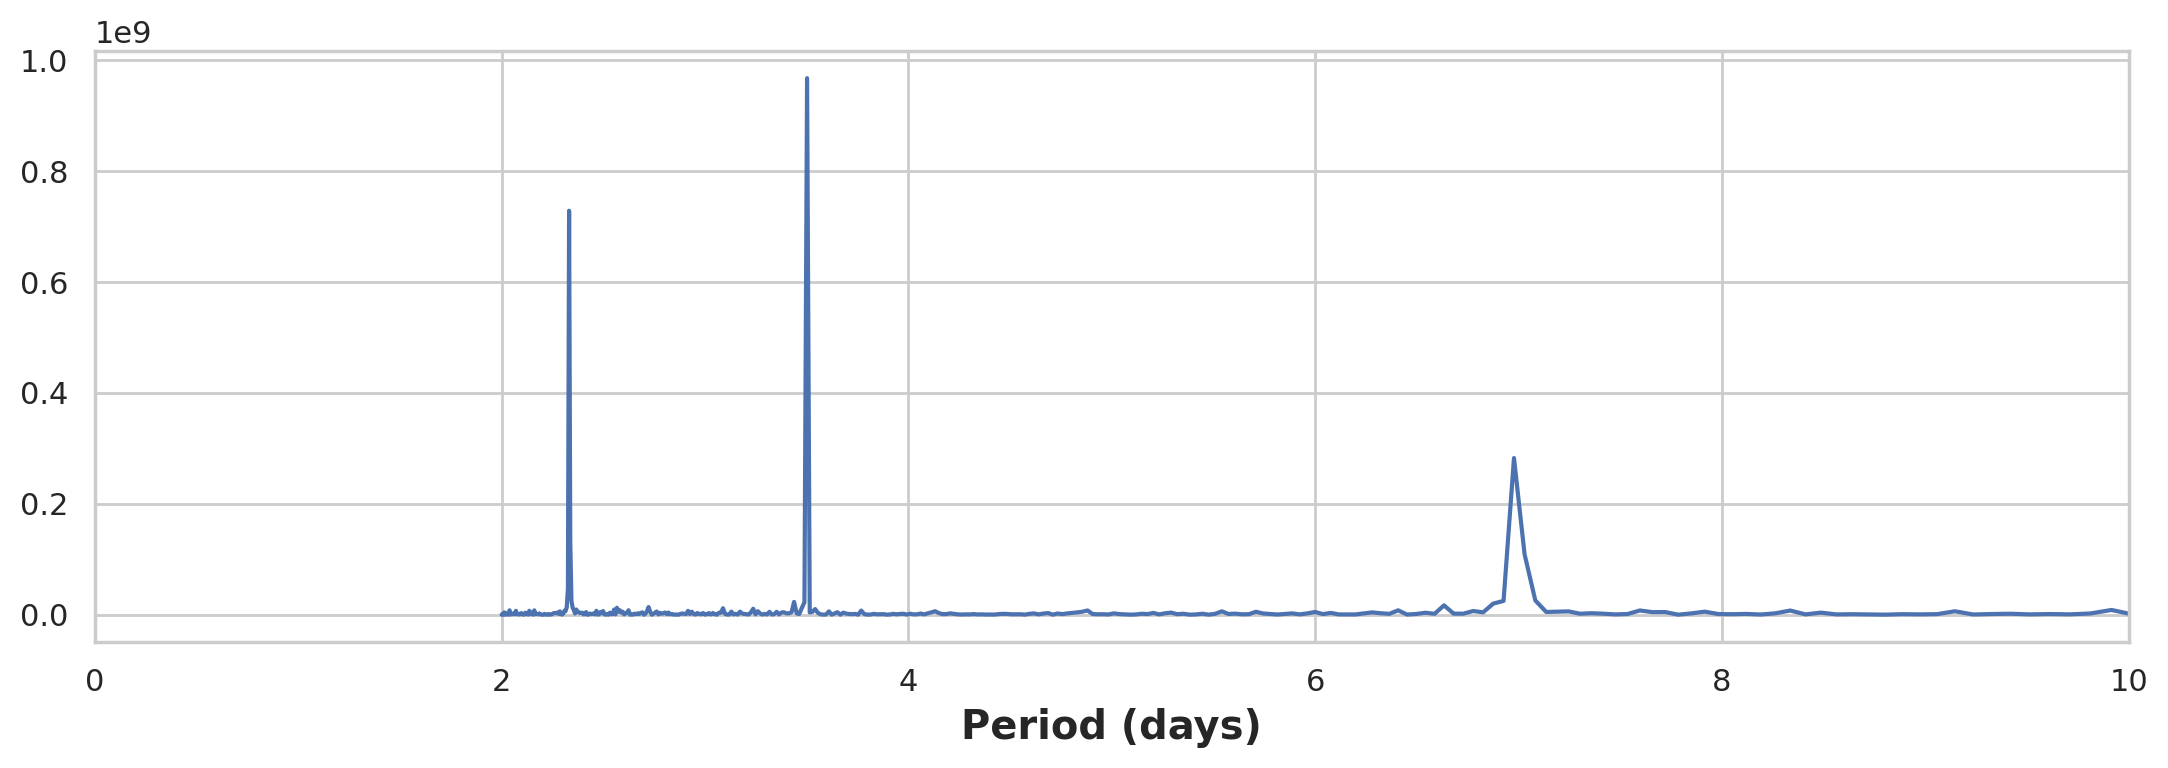

In [ ]:
from scipy.signal import periodogram#用于计算周期图
f,Pxx=periodogram(store1['Sales'].asfreq('D').fillna(0))
plt.plot(1/f,Pxx)
plt.xlim(0,10)
plt.xlabel('Period_for_Sales(days)')


我们发现周期2-4天有强烈信号，7天（周级）型号相对弱很多。这可能说明工作日/周末的销售量呈现较大差异

/tmp/ipykernel_8741/3773924792.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/f2,Pxx2)


(0.0, 10.0)

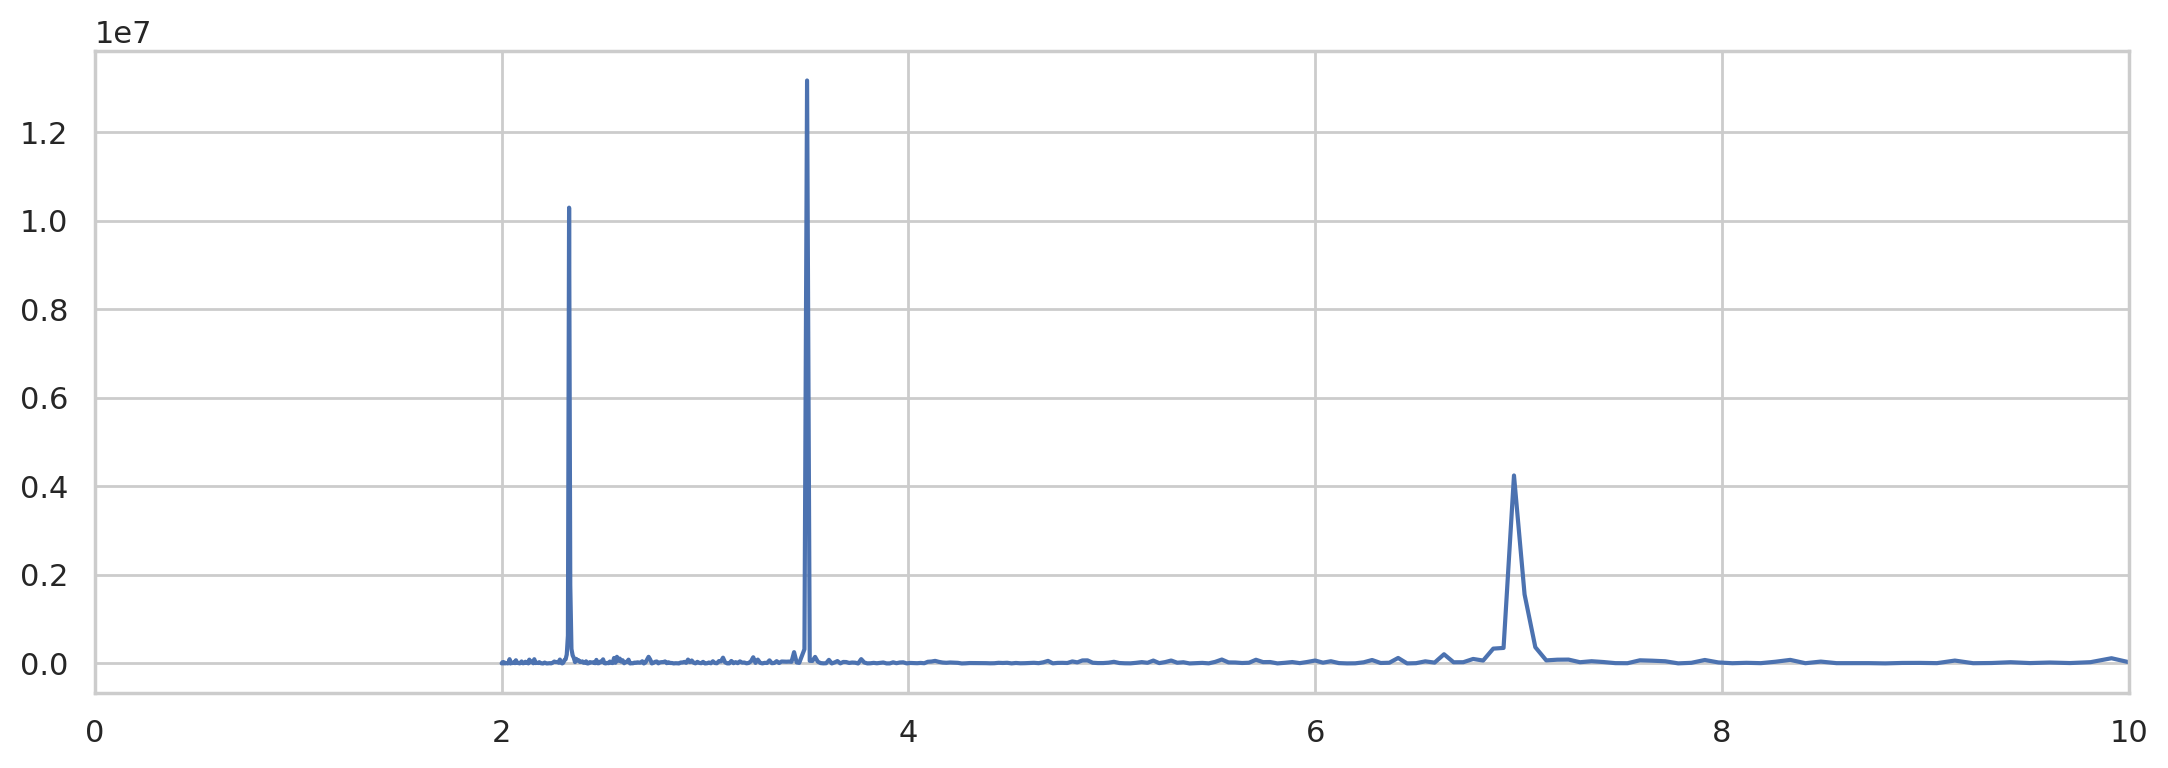

In [57]:
f2,Pxx2=periodogram(store1['Customers'].asfreq('D').fillna(0))
plt.plot(1/f2,Pxx2)
plt.xlim(0,10)

同样的，显示出同行周期